In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

## LGBMRegressor

In [ ]:
# !pip install deepctr-torch
# !pip install lightgbm
# !pip install optuna

In [1]:
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, MinMaxScaler
import matplotlib.pyplot as plt
from deepctr_torch.inputs import SparseFeat, get_feature_names, DenseFeat
from deepctr_torch.models import DeepFM
from sklearn.metrics import mean_absolute_error
import numpy as np
from lightgbm import LGBMRegressor,plot_importance,Dataset

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import time

2022-12-11 04:27:36.388284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 04:27:37.420816: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-11 04:27:37.420914: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-11 04:27:37.420923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# Main Train 파일 로드
Ori_Train = pd.read_csv('./Train/Train.csv', encoding='utf-8')

# 엑셀파일이기에 read_excel로 로드
Sub_Data = pd.read_excel('./Train/ETC_Data/Main_Subjects.xlsx')

# test file 업로드

test = pd.read_csv('Test.csv')

# 제출 파일 업로드
submission = pd.read_csv('Sample_Submission.csv')
submission = submission.drop(columns = ['Unnamed: 0'])

In [3]:
Basic = pd.read_excel('Train/ETC_Data/Basic.xlsx')
# Detail_Info = pd.read_excel('Train/ETC_Data/Detail_Info.xlsx')
# Main_Subjects = pd.read_excel('Train/ETC_Data/Main_Subjects.xlsx')
# Medical_Facility = pd.read_excel('Train/ETC_Data/Medical_Facility.xlsx')
# Reception_Reservation_Days = pd.read_csv('Train/ETC_Data/Reception_Reservation_Days_2022.CSV',encoding='utf-8')
# Transportation = pd.read_excel('Train/ETC_Data/Transportation.xlsx')

In [4]:
# Primary Key 별로 진료과목 정리
Sub_Data = Sub_Data.groupby(['암호화요양기호'])['진료과목코드명'].apply(','.join).reset_index()
# 오름차순 정렬
Sub_Data['진료과목코드명'] = Sub_Data['진료과목코드명'].apply(lambda x: sorted(set(x.split(','))))

In [5]:
# Basic Data를 보고 nan값을 채워넣을 수 있을지

Basic = Basic[['암호화요양기호', '좌표(X)', '좌표(Y)']]
Sub_Basic = pd.merge(Sub_Data, Basic, left_on='암호화요양기호', right_on='암호화요양기호', how='left')
Sub_Basic

,암호화요양기호,진료과목코드명,좌표(X),좌표(Y)
0,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[가정의학과, 내과, 비뇨의학과, 사상체질과, 산부인과, 침구과, 한방내과, 한방부...",129.036996,35.099979
1,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[사상체질과, 재활의학과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신...",129.044640,35.126467
2,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[영상의학과, 침구과, 한방내과, 한방신경정신과, 한방안·이비인후·피부과, 한방재활...",129.175263,35.169667
3,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[사상체질과, 재활의학과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신...",129.077525,35.205376
4,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[사상체질과, 정형외과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신과...",129.099260,35.137340
...,...,...,...,...
72583,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"[가정의학과, 산부인과, 성형외과, 피부과]",127.154242,37.508778
72584,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"[가정의학과, 내과, 비뇨의학과, 소아청소년과, 이비인후과, 피부과]",127.112248,37.650579
72585,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"[가정의학과, 피부과]",127.244136,37.654116
72586,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,[이비인후과],126.712599,37.593903


### 전처리 방향

columns 추가

['USER_ID', 'Question_ID', 'HOSPITAL_CD', 'TIME', '종별코드', '시도코드명', '시군구코드', '개설일자', '총의사수', 'x좌표', 'y좌표']
       
현재 ['USER_ID', 'HOSPITAL_ID', '시군구코드', 'x', 'y', '시도코드명', '총의사수', '종별코드', 'TIME', '개설일자']


X,Y 좌표는 일단 평균값으로 전처리 한다

time 날짜 떼고 min max scaling

개설일자(개원일 예상, 오랫동안 운영했을 경우 평점이 더 높을까)


좌표(X)와 x좌표 중 큰 값으로 최대한 Nan값을 채웠다

둘 다 Nan 값을 가지는 것은 18개

이건 버릴건지?
평균으로 채울건지?

## 추가로 고려해 볼 feature
- TIME? , 총의사수

Question_ID = USER_ID + HOSPITAL_ID = Identity_ID

In [124]:
# Data Merge
Merged_Train = pd.merge(Ori_Train, Sub_Basic, left_on='HOSPITAL_CD', right_on='암호화요양기호',how='left')
Merged_Train

,Unnamed: 0,USER_ID,REG_DATE,TOTAL_RATE,TX_RATE,SERVICE_RATE,ETC_RATE,CONTENTS,HOSPITAL_CD,HOSPITAL_NM,...,병원홈페이지(URL),개설일자,총의사수,x좌표,y좌표,Identity_Key,암호화요양기호,진료과목코드명,좌표(X),좌표(Y)
0,0,4.778650e+05,2018-07-23 09:24:08,9.0,8.0,10.0,8.0,볼지방제거와 밴드리프팅 한지 한달됐어요 많이 가름해졌어요 좀더 지켜봐야 할것같다,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,477865_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
1,1,2.010333e+11,2018-07-23 09:59:15,10.0,10.0,10.0,10.0,너무좋은데. 아직 좀지켜봐야알겠지만 예뻐질것같은 느낌이예요,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,201033325523_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
2,2,3.381810e+05,2018-07-23 10:00:57,10.0,10.0,10.0,10.0,꼭당첨!!!,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,338181_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
3,3,2.010326e+11,2018-07-24 12:57:55,5.0,6.0,6.0,4.0,무제한 보톡스 는 아닌것 같아요 보톡스를 맞기 위한 옷 이 없어 기다림 남이 입건것...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,201032630325_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
4,4,4.998490e+05,2018-07-25 10:08:18,10.0,10.0,10.0,10.0,NaN,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,499849_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48433,167863,2.440542e+06,2022-09-25 04:32:05.963774,8.0,6.0,10.0,10.0,시설 좋고 선생님도 젊으세요 대신 사람이 많아서 그만큼 많이 기다려야해요 수액 놓는...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,벗이비인후과의원,...,NaN,2021-04-12 00:00:00,1,127.071848,37.534118,2440542_72069,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,"[내과, 소아청소년과, 신경과, 이비인후과]",127.071848,37.534118
48434,167864,1.658243e+06,2022-09-27 01:22:27.485015,6.0,6.0,6.0,6.0,소이과 되어있어서 왔는데 소아과가 없대서 아가인고 돌아갑니다 ㅜㅜ,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,전영수내과의원,...,NaN,1995-06-17 00:00:00,1,126.905218,37.479841,1658243_73445,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,"[내과, 소아청소년과]",126.905218,37.479841
48435,167865,2.445760e+06,2022-09-27 05:42:37.378565,10.0,10.0,10.0,10.0,좋은말씀 많이해주세요,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,마음담은정신건강의학과의원,...,NaN,2022-04-20 00:00:00,1,NaN,NaN,2445760_79673,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,[정신건강의학과],127.089398,37.580735
48436,167866,2.452015e+06,2022-10-02 02:04:41.373758,10.0,10.0,10.0,10.0,명의이십니다 보통 한의원과는 차원이 달라요 아토피 정신과 허리 치료 받았습니다,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,다스름한의원,...,NaN,2019-02-07 00:00:00,1,127.070530,37.456457,2452015_25306,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,"[사상체질과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신과, 한방안·...",127.070530,37.456457


In [125]:
Merged_Train[['x좌표', 'y좌표', '좌표(X)', '좌표(Y)']] = Merged_Train[['x좌표', 'y좌표', '좌표(X)', '좌표(Y)']].fillna(0)

In [126]:
x = []
y = []

for i in range(48438):
    if Merged_Train['좌표(X)'][i] > Merged_Train['x좌표'][i]:
        x.append(Merged_Train['좌표(X)'][i])
    elif Merged_Train['좌표(X)'][i] <= Merged_Train['x좌표'][i]:
        x.append(Merged_Train['x좌표'][i])
    else:
        x.append(np.nan)

for j in range(48438):
    if Merged_Train['좌표(Y)'][j] > Merged_Train['y좌표'][j]:
        y.append(Merged_Train['좌표(Y)'][j])
    elif Merged_Train['좌표(Y)'][j] <= Merged_Train['y좌표'][j]:
        y.append(Merged_Train['y좌표'][j])
    else:
        y.append(np.nan)

In [127]:
xy = pd.DataFrame([x for x in zip(x, y)])
xy.columns =['x', 'y']
xy

,x,y
0,127.021476,37.517322
1,127.021476,37.517322
2,127.021476,37.517322
3,127.021476,37.517322
4,127.021476,37.517322
...,...,...
48433,127.071848,37.534118
48434,126.905218,37.479841
48435,127.089398,37.580735
48436,127.070530,37.456457


In [128]:
xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48438 entries, 0 to 48437
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       48438 non-null  float64
 1   y       48438 non-null  float64
dtypes: float64(2)
memory usage: 757.0 KB


In [129]:
Merged_Train = pd.concat([Merged_Train, xy], axis=1)
Merged_Train = Merged_Train.drop(columns = ['x좌표', 'y좌표', '좌표(X)', '좌표(Y)'])
Merged_Train

,Unnamed: 0,USER_ID,REG_DATE,TOTAL_RATE,TX_RATE,SERVICE_RATE,ETC_RATE,CONTENTS,HOSPITAL_CD,HOSPITAL_NM,...,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,Identity_Key,암호화요양기호,진료과목코드명,x,y
0,0,4.778650e+05,2018-07-23 09:24:08,9.0,8.0,10.0,8.0,볼지방제거와 밴드리프팅 한지 한달됐어요 많이 가름해졌어요 좀더 지켜봐야 할것같다,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,477865_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
1,1,2.010333e+11,2018-07-23 09:59:15,10.0,10.0,10.0,10.0,너무좋은데. 아직 좀지켜봐야알겠지만 예뻐질것같은 느낌이예요,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,201033325523_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
2,2,3.381810e+05,2018-07-23 10:00:57,10.0,10.0,10.0,10.0,꼭당첨!!!,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,338181_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
3,3,2.010326e+11,2018-07-24 12:57:55,5.0,6.0,6.0,4.0,무제한 보톡스 는 아닌것 같아요 보톡스를 맞기 위한 옷 이 없어 기다림 남이 입건것...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,201032630325_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
4,4,4.998490e+05,2018-07-25 10:08:18,10.0,10.0,10.0,10.0,NaN,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,499849_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48433,167863,2.440542e+06,2022-09-25 04:32:05.963774,8.0,6.0,10.0,10.0,시설 좋고 선생님도 젊으세요 대신 사람이 많아서 그만큼 많이 기다려야해요 수액 놓는...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,벗이비인후과의원,...,광진구,02-6953-5805,NaN,2021-04-12 00:00:00,1,2440542_72069,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,"[내과, 소아청소년과, 신경과, 이비인후과]",127.071848,37.534118
48434,167864,1.658243e+06,2022-09-27 01:22:27.485015,6.0,6.0,6.0,6.0,소이과 되어있어서 왔는데 소아과가 없대서 아가인고 돌아갑니다 ㅜㅜ,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,전영수내과의원,...,금천구,02-859-3500,NaN,1995-06-17 00:00:00,1,1658243_73445,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,"[내과, 소아청소년과]",126.905218,37.479841
48435,167865,2.445760e+06,2022-09-27 05:42:37.378565,10.0,10.0,10.0,10.0,좋은말씀 많이해주세요,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,마음담은정신건강의학과의원,...,중랑구,02-2038-3070,NaN,2022-04-20 00:00:00,1,2445760_79673,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,[정신건강의학과],127.089398,37.580735
48436,167866,2.452015e+06,2022-10-02 02:04:41.373758,10.0,10.0,10.0,10.0,명의이십니다 보통 한의원과는 차원이 달라요 아토피 정신과 허리 치료 받았습니다,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,다스름한의원,...,서초구,02-529-7522,NaN,2019-02-07 00:00:00,1,2452015_25306,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,"[사상체질과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신과, 한방안·...",127.070530,37.456457


In [130]:
Merged_Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48438 entries, 0 to 48437
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    48438 non-null  int64  
 1   USER_ID       48438 non-null  float64
 2   REG_DATE      48438 non-null  object 
 3   TOTAL_RATE    48438 non-null  float64
 4   TX_RATE       48438 non-null  float64
 5   SERVICE_RATE  48438 non-null  float64
 6   ETC_RATE      48438 non-null  float64
 7   CONTENTS      43903 non-null  object 
 8   HOSPITAL_CD   48438 non-null  object 
 9   HOSPITAL_NM   48438 non-null  object 
 10  ADD           48438 non-null  object 
 11  HOSPITAL_ID   48438 non-null  int64  
 12  TIME          48438 non-null  object 
 13  요양기관명         48438 non-null  object 
 14  종별코드          48438 non-null  int64  
 15  종별코드명         48438 non-null  object 
 16  시도코드          48438 non-null  int64  
 17  시도코드명         48438 non-null  object 
 18  시군구코드         48438 non-nu

In [131]:
# NaN값 처리
Merged_Train.dropna(subset=['진료과목코드명'], inplace=True)
Merged_Train = Merged_Train.reset_index()
# Merged_Train[Merged_Train.isna().any(axis=1)]
# Merged_Train.dropna(subset=['x'], inplace = True)
# Merged_Train['진료과목코드명'] = Merged_Train['진료과목코드명'].fillna('X')

In [132]:
Merged_Train

,index,Unnamed: 0,USER_ID,REG_DATE,TOTAL_RATE,TX_RATE,SERVICE_RATE,ETC_RATE,CONTENTS,HOSPITAL_CD,...,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,Identity_Key,암호화요양기호,진료과목코드명,x,y
0,0,0,4.778650e+05,2018-07-23 09:24:08,9.0,8.0,10.0,8.0,볼지방제거와 밴드리프팅 한지 한달됐어요 많이 가름해졌어요 좀더 지켜봐야 할것같다,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,477865_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
1,1,1,2.010333e+11,2018-07-23 09:59:15,10.0,10.0,10.0,10.0,너무좋은데. 아직 좀지켜봐야알겠지만 예뻐질것같은 느낌이예요,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,201033325523_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
2,2,2,3.381810e+05,2018-07-23 10:00:57,10.0,10.0,10.0,10.0,꼭당첨!!!,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,338181_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
3,3,3,2.010326e+11,2018-07-24 12:57:55,5.0,6.0,6.0,4.0,무제한 보톡스 는 아닌것 같아요 보톡스를 맞기 위한 옷 이 없어 기다림 남이 입건것...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,201032630325_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
4,4,4,4.998490e+05,2018-07-25 10:08:18,10.0,10.0,10.0,10.0,NaN,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,499849_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48431,48433,167863,2.440542e+06,2022-09-25 04:32:05.963774,8.0,6.0,10.0,10.0,시설 좋고 선생님도 젊으세요 대신 사람이 많아서 그만큼 많이 기다려야해요 수액 놓는...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,...,광진구,02-6953-5805,NaN,2021-04-12 00:00:00,1,2440542_72069,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,"[내과, 소아청소년과, 신경과, 이비인후과]",127.071848,37.534118
48432,48434,167864,1.658243e+06,2022-09-27 01:22:27.485015,6.0,6.0,6.0,6.0,소이과 되어있어서 왔는데 소아과가 없대서 아가인고 돌아갑니다 ㅜㅜ,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,...,금천구,02-859-3500,NaN,1995-06-17 00:00:00,1,1658243_73445,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,"[내과, 소아청소년과]",126.905218,37.479841
48433,48435,167865,2.445760e+06,2022-09-27 05:42:37.378565,10.0,10.0,10.0,10.0,좋은말씀 많이해주세요,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,...,중랑구,02-2038-3070,NaN,2022-04-20 00:00:00,1,2445760_79673,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,[정신건강의학과],127.089398,37.580735
48434,48436,167866,2.452015e+06,2022-10-02 02:04:41.373758,10.0,10.0,10.0,10.0,명의이십니다 보통 한의원과는 차원이 달라요 아토피 정신과 허리 치료 받았습니다,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,...,서초구,02-529-7522,NaN,2019-02-07 00:00:00,1,2452015_25306,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,"[사상체질과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신과, 한방안·...",127.070530,37.456457


In [133]:
for i in tqdm(range(48436)):
    Merged_Train.TIME[i] = Merged_Train.TIME[i][11:13]

100%|███████████████████████████████████| 48436/48436 [00:33<00:00, 1427.33it/s]


In [134]:
for j in tqdm(range(48436)):
    Merged_Train['개설일자'][j] = Merged_Train['개설일자'][j][:4]

100%|███████████████████████████████████| 48436/48436 [00:30<00:00, 1581.48it/s]


In [135]:
Merged_Train['개설일자'].value_counts()

2018    8553
2015    5783
2019    5409
2016    4554
2017    3840
2013    3601
2014    1967
2020    1727
2011    1450
2002    1226
1999    1093
2009     940
2021     913
2010     758
2008     754
2006     713
2012     650
2005     582
2007     503
2004     499
2001     440
2003     376
2000     367
1998     184
1996     143
1991     139
1993     123
1995     118
1994     109
1997      93
1992      84
1990      79
1989      72
2022      67
1986      55
1988      51
1980      51
1985      43
1982      41
1987      41
1983      37
1984      34
1981      33
1974      27
1978      20
1979      17
1973      13
1977      12
1975      10
1976       9
1966       8
1972       6
1971       6
1961       4
1965       3
1969       3
1970       1
1968       1
1967       1
Name: 개설일자, dtype: int64

In [136]:
Merged_Train.TIME = Merged_Train.TIME.astype('float')
Merged_Train['개설일자'] = Merged_Train['개설일자'].astype('float')
Merged_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48436 entries, 0 to 48435
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         48436 non-null  int64  
 1   Unnamed: 0    48436 non-null  int64  
 2   USER_ID       48436 non-null  float64
 3   REG_DATE      48436 non-null  object 
 4   TOTAL_RATE    48436 non-null  float64
 5   TX_RATE       48436 non-null  float64
 6   SERVICE_RATE  48436 non-null  float64
 7   ETC_RATE      48436 non-null  float64
 8   CONTENTS      43901 non-null  object 
 9   HOSPITAL_CD   48436 non-null  object 
 10  HOSPITAL_NM   48436 non-null  object 
 11  ADD           48436 non-null  object 
 12  HOSPITAL_ID   48436 non-null  int64  
 13  TIME          48436 non-null  float64
 14  요양기관명         48436 non-null  object 
 15  종별코드          48436 non-null  int64  
 16  종별코드명         48436 non-null  object 
 17  시도코드          48436 non-null  int64  
 18  시도코드명         48436 non-nu

In [ ]:
# 중앙값(df.median)으로 NaN 채우기, 최빈값 df.mode(), 최대값

# Final_Train[Final_Train.isna().any(axis=1)]
# Final_Train = Final_Train.dropna()
# Final_Train = Final_Train.fillna(Final_Train.median(numeric_only = True))
'''
# x,y Nan값 제대로 concat 하니 Nan값이 사라짐
Merged_Train['x'] = Merged_Train['x'].fillna(Merged_Train['x'].mode()[0])
Merged_Train['y'] = Merged_Train['y'].fillna(Merged_Train['y'].mode()[0])
Merged_Train
'''

In [141]:
# Muliti Label Onehot
mlb = MultiLabelBinarizer()
Encoded_Value = mlb.fit_transform(Merged_Train['진료과목코드명'])
Hospital_Class = mlb.classes_
Hospital_Class = ['진료과목'+'_'+ k for k in Hospital_Class]
One_Hot_Classes = pd.DataFrame(Encoded_Value, columns = Hospital_Class)
Merged_Train = Merged_Train.drop('진료과목코드명', axis=1).reset_index()

Refined_Train = pd.concat([Merged_Train, One_Hot_Classes], axis=1)

KeyError: '진료과목코드명'

In [142]:
# test data에 없는 컬럼 제거
Refined_Train = Refined_Train.drop(columns='진료과목_비뇨기과')

KeyError: "['진료과목_비뇨기과'] not found in axis"

In [221]:
# 학습에 활용할 모든 Column
ALL_FIELDS = ['HOSPITAL_ID', 'x', 'y', '총의사수', '종별코드', 'TIME', '개설일자', 'USER_ID', '시군구코드']
# 'USER_ID', '시군구코드', '시도코드명', 

# 학습에 활용할 모든 Column
Subject_FIELDS = [k for k in Refined_Train.columns if k.startswith('진료과목')]

# 연속형 변수가 담긴 Column
CONT_FIELDS = ['x','y', '종별코드', '시군구코드', '개설일자', '총의사수', '개설일자', 'TIME', 'USER_ID', 'HOSPITAL_ID']

# 범주형 변수가 담긴 Column > One Hot Encoding으로 변경해야함
CAT_FIELDS = list(set(ALL_FIELDS).difference(CONT_FIELDS)) + Subject_FIELDS

mms = MinMaxScaler(feature_range=(0,1))
Refined_Train[CONT_FIELDS] = mms.fit_transform(Refined_Train[CONT_FIELDS]) 

for feat in CAT_FIELDS:
    lbe = LabelEncoder()
    Refined_Train[feat] = lbe.fit_transform(Refined_Train[feat])

fixlen_feature_columns = [SparseFeat(feat, Refined_Train[feat].nunique()) for feat in CAT_FIELDS] + [DenseFeat(feat,1,)for feat in CONT_FIELDS]
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

DeepFM_Train_Columns = get_feature_names(fixlen_feature_columns)
DeepFM_Train_Columns.append('TOTAL_RATE')

Final_Train = Refined_Train[DeepFM_Train_Columns].reset_index().drop(columns=['index'])



In [198]:
Final_Test

,HOSPITAL_ID,종별코드,TIME,시군구코드,개설일자,시도코드명,총의사수,USER_ID,진료과목_가정의학과,진료과목_결핵과,...,진료과목_한방소아과,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과,x,y,Predict_Score
0,529,4,17,0,40,1,19,624,0,0,...,0,0,0,0,0,0,0,0.632479,0.404976,1
1,215,8,0,0,39,1,4,1167,0,0,...,1,1,1,1,1,0,0,0.639677,0.366401,1
2,608,4,5,0,42,1,17,751,0,0,...,0,0,0,0,0,0,0,0.640395,0.364644,1
3,322,4,3,20,43,1,2,1077,0,0,...,0,0,0,0,0,0,0,0.643883,0.348439,1
4,376,8,9,21,36,1,1,471,0,0,...,1,1,1,0,1,0,0,0.747285,0.905001,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,550,4,10,20,37,1,3,980,0,0,...,0,0,0,0,0,0,0,0.644173,0.347710,1
1402,539,4,10,0,23,1,1,980,0,0,...,0,0,0,0,0,0,0,0.689858,0.439386,1
1403,631,4,10,20,43,1,1,980,0,0,...,0,0,0,0,0,0,0,0.645492,0.343036,1
1404,521,4,4,12,42,1,6,989,0,0,...,0,0,0,0,0,0,0,0.290058,0.406108,1


In [ ]:
'''

## x, y 좌표 빼 보기


# 학습에 활용할 모든 Column
ALL_FIELDS = ['USER_ID', 'HOSPITAL_ID', '시군구코드']

# 학습에 활용할 모든 Column
Subject_FIELDS = [k for k in Refined_Train.columns if k.startswith('진료과목')]

# 범주형 변수가 담긴 Column > One Hot Encoding으로 변경해야함
CAT_FIELDS = list(set(ALL_FIELDS)) + Subject_FIELDS

mms = MinMaxScaler(feature_range=(0,1))

for feat in CAT_FIELDS:
    lbe = LabelEncoder()
    Refined_Train[feat] = lbe.fit_transform(Refined_Train[feat])

fixlen_feature_columns = [SparseFeat(feat, Refined_Train[feat].nunique()) for feat in CAT_FIELDS]
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

DeepFM_Train_Columns = get_feature_names(fixlen_feature_columns)
DeepFM_Train_Columns.append('TOTAL_RATE')

Final_Train = Refined_Train[DeepFM_Train_Columns]
# NaN 값 채우기
# Final_Train[Final_Train.isna().any(axis=1)]
Final_Train = Final_Train.fillna(0)
Final_Train
'''

In [ ]:
'''
# 모델 결과 출력
plt.plot(history.history["loss"])
plt.plot(history.history["val_mse"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"], loc="upper left")
plt.show()
'''

## test data 전처리

In [147]:
# train data와 같은 방식으로 Sub_Data와 Merge

# Merged_Test = pd.merge(test, Sub_Basic, left_on='HOSPITAL_CD',right_on='암호화요양기호',how='left')
Merged_Test = pd.merge(test, Sub_Basic, left_on='HOSPITAL_CD',right_on='암호화요양기호',how='left')

In [ ]:
test

병원 코드가 같다 = 같은 병원 = x,y 좌표가 같다

In [ ]:
print(Merged_Test[Merged_Test['x좌표'].isnull()].index)
print(Merged_Test[Merged_Test['y좌표'].isnull()].index)
print(Merged_Test[Merged_Test['좌표(X)'].isnull()].index)
print(Merged_Test[Merged_Test['좌표(Y)'].isnull()].index)

두 data를 묶는다면 x,y 좌표 Nan값들을 확실하게 채워줄 수 있다

In [ ]:
Merged_Test.info()

In [148]:
Merged_Test[['x좌표', 'y좌표', '좌표(X)', '좌표(Y)']] = Merged_Test[['x좌표', 'y좌표', '좌표(X)', '좌표(Y)']].fillna(0)

In [149]:
x_t = []
y_t = []

for i in range(1406):
    if Merged_Test['좌표(X)'][i] > Merged_Test['x좌표'][i]:
        x_t.append(Merged_Test['좌표(X)'][i])
    elif Merged_Test['좌표(X)'][i] <= Merged_Test['x좌표'][i]:
        x_t.append(Merged_Test['x좌표'][i])
    else:
        x_t.append(np.nan)

for j in range(1406):
    if Merged_Test['좌표(Y)'][j] > Merged_Test['y좌표'][j]:
        y_t.append(Merged_Test['좌표(Y)'][j])
    elif Merged_Test['좌표(Y)'][j] <= Merged_Test['y좌표'][j]:
        y_t.append(Merged_Test['y좌표'][j])
    else:
        y_t.append(np.nan)


In [150]:
xy_t = pd.DataFrame([x for x in zip(x_t, y_t)])
xy_t.columns =['x', 'y']
xy_t

,x,y
0,127.021476,37.517322
1,127.023893,37.506695
2,127.024134,37.506211
3,127.025305,37.501747
4,127.060019,37.655075
...,...,...
1401,127.025402,37.501546
1402,127.040740,37.526802
1403,127.025845,37.500259
1404,126.906519,37.517634


In [ ]:
# Merged_Test.x[Merged_Test['x'].isna()]
# Merged_Test.y[Merged_Test['y'].isna()]

In [151]:
Merged_Test = pd.concat([Merged_Test, xy_t], axis=1)
Merged_Test = Merged_Test.drop(columns = ['x좌표', 'y좌표', '좌표(X)', '좌표(Y)'])
# Merged_Test.dropna(subset=['x','y'], inplace = True)
Merged_Test.reset_index(inplace=True)

In [ ]:
Merged_Test.info()

In [152]:
for i in tqdm(range(1406)):
    Merged_Test.TIME[i] = Merged_Test.TIME[i][11:13]
    
for j in tqdm(range(1406)):
    Merged_Test['개설일자'][j] = Merged_Test['개설일자'][j][:4]

Merged_Test.TIME = Merged_Test.TIME.astype('float')
Merged_Test['개설일자'] = Merged_Test['개설일자'].astype('float')
Merged_Test.info()

100%|█████████████████████████████████████| 1406/1406 [00:00<00:00, 2401.65it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          1406 non-null   int64  
 1   Unnamed: 0     1406 non-null   int64  
 2   USER_ID        1406 non-null   int64  
 3   Question_ID    1406 non-null   object 
 4   HOSPITAL_CD    1406 non-null   object 
 5   HOSPITAL_NM    1406 non-null   object 
 6   ADD            1406 non-null   object 
 7   HOSPITAL_ID    1406 non-null   int64  
 8   TIME           1406 non-null   float64
 9   요양기관명          1406 non-null   object 
 10  종별코드           1406 non-null   int64  
 11  종별코드명          1406 non-null   object 
 12  시도코드           1406 non-null   int64  
 13  시도코드명          1406 non-null   object 
 14  시군구코드          1406 non-null   int64  
 15  시군구코드명         1406 non-null   object 
 16  전화번호           1381 non-null   object 
 17  병원홈페이지(URL)    475 non-null    object 
 18  개설일자    

In [ ]:
Merged_Test['개설일자']

In [ ]:


# Final_Test[Final_Test.isna().any(axis=1)]
# Final_Test = Final_Test.dropna()
# Final_Test

# Final_Test = Final_Test.fillna(Final_Test.median(numeric_only = True))
'''
# x,y 좌표 Basic과 연계
Merged_Test['x'] = Merged_Test['x'].fillna(Merged_Test['x'].mode()[0])
Merged_Test['y'] = Merged_Test['y'].fillna(Merged_Test['y'].mode()[0])

# test data 기본 data + 평균값
Merged_Test['x'] = Merged_Test['x'].fillna(Merged_Test['x'].mode()[0])
Merged_Test['y'] = Merged_Test['y'].fillna(Merged_Test['y'].mode()[0])

Merged_Test
'''

In [153]:
# Muliti Label Onehot
mlb = MultiLabelBinarizer()
Encoded_Value = mlb.fit_transform(Merged_Test['진료과목코드명'])
Hospital_Class = mlb.classes_
Hospital_Class = ['진료과목'+'_'+ k for k in Hospital_Class]
One_Hot_Classes = pd.DataFrame(Encoded_Value, columns = Hospital_Class)
Merged_Test = Merged_Test.drop('진료과목코드명', axis=1)

Refined_Test = pd.concat([Merged_Test, One_Hot_Classes], axis=1)

In [222]:
# 학습에 활용할 모든 Column
ALL_FIELDS = ['HOSPITAL_ID', 'x', 'y', '총의사수', '종별코드', 'TIME', '개설일자','USER_ID', '시군구코드']
# 'USER_ID', '시군구코드', '시도코드명', 

# 학습에 활용할 모든 Column
Subject_FIELDS = [k for k in Refined_Test.columns if k.startswith('진료과목')]

# 연속형 변수가 담긴 Column
CONT_FIELDS = ['x','y', '종별코드', '시군구코드', '개설일자', '총의사수', '개설일자', 'TIME' ,'USER_ID', 'HOSPITAL_ID']

# 범주형 변수가 담긴 Column > One Hot Encoding으로 변경해야함
CAT_FIELDS = list(set(ALL_FIELDS).difference(CONT_FIELDS)) + Subject_FIELDS

mms = MinMaxScaler(feature_range=(0,1))
Refined_Test[CONT_FIELDS] = mms.fit_transform(Refined_Test[CONT_FIELDS])

for feat in CAT_FIELDS:
    lbe = LabelEncoder()
    Refined_Test[feat] = lbe.fit_transform(Refined_Test[feat])

fixlen_feature_columns = [SparseFeat(feat, Refined_Test[feat].nunique()) for feat in CAT_FIELDS] + [DenseFeat(feat,1,)for feat in CONT_FIELDS]
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

DeepFM_Test_Columns = get_feature_names(fixlen_feature_columns)
DeepFM_Test_Columns.append('Predict_Score')

Final_Test = Refined_Test[DeepFM_Test_Columns]


In [202]:
Final_Test

,HOSPITAL_ID,USER_ID,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,진료과목_마취통증의학과,진료과목_방사선종양학과,...,진료과목_핵의학과,진료과목_흉부외과,x,y,종별코드,시군구코드,개설일자,총의사수,TIME,Predict_Score
0,529,624,0,0,0,0,0,0,0,0,...,0,0,0.632479,0.404976,0.5,0.00,0.869565,0.558824,0.739130,1
1,215,1167,0,0,0,0,0,0,0,0,...,0,0,0.639677,0.366401,1.0,0.00,0.847826,0.117647,0.000000,1
2,608,751,0,0,0,0,0,0,0,0,...,0,0,0.640395,0.364644,0.5,0.00,0.913043,0.500000,0.217391,1
3,322,1077,0,0,0,0,0,0,1,0,...,0,0,0.643883,0.348439,0.5,0.80,0.934783,0.058824,0.130435,1
4,376,471,0,0,0,0,0,0,0,0,...,0,0,0.747285,0.905001,1.0,0.84,0.782609,0.029412,0.391304,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,550,980,0,0,0,0,0,0,0,0,...,0,0,0.644173,0.347710,0.5,0.80,0.804348,0.088235,0.434783,1
1402,539,980,0,0,0,0,0,0,0,0,...,0,0,0.689858,0.439386,0.5,0.00,0.500000,0.029412,0.434783,1
1403,631,980,0,0,0,0,0,0,0,0,...,0,0,0.645492,0.343036,0.5,0.80,0.934783,0.029412,0.434783,1
1404,521,989,0,0,0,0,0,0,0,0,...,0,0,0.290058,0.406108,0.5,0.48,0.913043,0.176471,0.173913,1


In [ ]:
'''
x, y 좌표 빼 보기


# 학습에 활용할 모든 Column
ALL_FIELDS = ['USER_ID', 'HOSPITAL_ID', '시군구코드']

# 학습에 활용할 모든 Column
Subject_FIELDS = [k for k in Refined_Test.columns if k.startswith('진료과목')]

# 범주형 변수가 담긴 Column > One Hot Encoding으로 변경해야함
CAT_FIELDS = list(set(ALL_FIELDS)) + Subject_FIELDS

mms = MinMaxScaler(feature_range=(0,1))

for feat in CAT_FIELDS:
    lbe = LabelEncoder()
    Refined_Test[feat] = lbe.fit_transform(Refined_Test[feat])

fixlen_feature_columns = [SparseFeat(feat, Refined_Test[feat].nunique()) for feat in CAT_FIELDS]
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

DeepFM_Test_Columns = get_feature_names(fixlen_feature_columns)
DeepFM_Test_Columns.append('Predict_Score')

Final_Test = Refined_Test[DeepFM_Test_Columns]
# Final_Test[Final_Test.isna().any(axis=1)]

Final_Test = Final_Test.fillna(0)
Final_Test
'''

## LGBM 추가 앙상블 모델로서 학습하기?



In [ ]:
Final_Train.columns

In [223]:
for k in CAT_FIELDS:
    Final_Train[k]=Final_Train[k].astype('category')
    
lgbm_train_columns = get_feature_names(fixlen_feature_columns) 
    
X_train, X_test, y_train, y_test = train_test_split(Final_Train[lgbm_train_columns], Final_Train['TOTAL_RATE'], test_size=0.2, random_state = 1042)



In [224]:
trial_paramsss = {'max_depth': 18, 
                 'learning_rate': 0.0036079158200764488, 
                 'boosting_type': 'gbdt',
                 'n_estimators': 2018, 
                 'min_child_samples': 26, 
                 'subsample': 0.4715832342831849,
                 'num_leaves' : 500,
                 'bagging_fraction' : 0.5}


In [225]:
lgbm_wrapper = LGBMRegressor(**trial_paramsss)  # max_depth=20, min_child_samples=60, n_estimators=4000, num_leaves=50, subsample=0.8)
evals = [(X_train, y_train), (X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds = 1500, eval_metric='mae', eval_set = evals, verbose=True)


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.4715832342831849 will be ignored. Current value: bagging_fraction=0.5
[1]	training's l1: 1.68479	training's l2: 4.56922	valid_1's l1: 1.68421	valid_1's l2: 4.61176
[2]	training's l1: 1.68285	training's l2: 4.56036	valid_1's l1: 1.68257	valid_1's l2: 4.60486
[3]	training's l1: 1.68092	training's l2: 4.55157	valid_1's l1: 1.68095	valid_1's l2: 4.59803
[4]	training's l1: 1.679	training's l2: 4.54283	valid_1's l1: 1.67933	valid_1's l2: 4.59125
[5]	training's l1: 1.67708	training's l2: 4.53416	valid_1's l1: 1.67773	valid_1's l2: 4.58454
[6]	training's l1: 1.67517	training's l2: 4.52555	valid_1's l1: 1.67612	valid_1's l2: 4.57786
[7]	training's l1: 1.67327	training's l2: 4.51701	valid_1's l1: 1.67453	valid_1's l2: 4.57122
[8]	training's l1: 1.67137	training's l2: 4.50851	valid_1's l1: 1.67293	valid_1's l2: 4.56462
[9]	training's l1: 1.66947	training's l2: 4.50004	valid_1's l1: 1.67134	valid_1's l2: 4.55807
[10]	training's l1: 1.66

[97]	training's l1: 1.52624	training's l2: 3.93381	valid_1's l1: 1.55123	valid_1's l2: 4.13622
[98]	training's l1: 1.52487	training's l2: 3.9289	valid_1's l1: 1.55008	valid_1's l2: 4.13268
[99]	training's l1: 1.52349	training's l2: 3.92403	valid_1's l1: 1.54895	valid_1's l2: 4.12938
[100]	training's l1: 1.52213	training's l2: 3.91917	valid_1's l1: 1.54783	valid_1's l2: 4.12596
[101]	training's l1: 1.52077	training's l2: 3.91436	valid_1's l1: 1.54672	valid_1's l2: 4.12273
[102]	training's l1: 1.5194	training's l2: 3.90952	valid_1's l1: 1.54562	valid_1's l2: 4.11952
[103]	training's l1: 1.51805	training's l2: 3.90475	valid_1's l1: 1.5445	valid_1's l2: 4.11612
[104]	training's l1: 1.51669	training's l2: 3.89995	valid_1's l1: 1.54341	valid_1's l2: 4.11293
[105]	training's l1: 1.51534	training's l2: 3.89524	valid_1's l1: 1.54232	valid_1's l2: 4.10972
[106]	training's l1: 1.514	training's l2: 3.8905	valid_1's l1: 1.54122	valid_1's l2: 4.10638
[107]	training's l1: 1.51266	training's l2: 3.885

[193]	training's l1: 1.41614	training's l2: 3.558	valid_1's l1: 1.46545	valid_1's l2: 3.89618
[194]	training's l1: 1.41522	training's l2: 3.55499	valid_1's l1: 1.46478	valid_1's l2: 3.89451
[195]	training's l1: 1.41428	training's l2: 3.5519	valid_1's l1: 1.46408	valid_1's l2: 3.89283
[196]	training's l1: 1.41333	training's l2: 3.5488	valid_1's l1: 1.46338	valid_1's l2: 3.89117
[197]	training's l1: 1.41239	training's l2: 3.54572	valid_1's l1: 1.46271	valid_1's l2: 3.88956
[198]	training's l1: 1.41146	training's l2: 3.54267	valid_1's l1: 1.46203	valid_1's l2: 3.8878
[199]	training's l1: 1.41054	training's l2: 3.53971	valid_1's l1: 1.46136	valid_1's l2: 3.88621
[200]	training's l1: 1.40962	training's l2: 3.53668	valid_1's l1: 1.46068	valid_1's l2: 3.88457
[201]	training's l1: 1.4087	training's l2: 3.53373	valid_1's l1: 1.46002	valid_1's l2: 3.88298
[202]	training's l1: 1.40778	training's l2: 3.53071	valid_1's l1: 1.45932	valid_1's l2: 3.8812
[203]	training's l1: 1.40689	training's l2: 3.5

[289]	training's l1: 1.33859	training's l2: 3.3106	valid_1's l1: 1.4105	valid_1's l2: 3.77539
[290]	training's l1: 1.33789	training's l2: 3.30842	valid_1's l1: 1.41003	valid_1's l2: 3.77441
[291]	training's l1: 1.3372	training's l2: 3.30629	valid_1's l1: 1.40955	valid_1's l2: 3.77346
[292]	training's l1: 1.33651	training's l2: 3.30419	valid_1's l1: 1.40909	valid_1's l2: 3.77262
[293]	training's l1: 1.33583	training's l2: 3.30212	valid_1's l1: 1.40862	valid_1's l2: 3.77172
[294]	training's l1: 1.33514	training's l2: 3.29997	valid_1's l1: 1.40816	valid_1's l2: 3.7708
[295]	training's l1: 1.33446	training's l2: 3.29791	valid_1's l1: 1.40771	valid_1's l2: 3.76994
[296]	training's l1: 1.33378	training's l2: 3.29582	valid_1's l1: 1.40723	valid_1's l2: 3.769
[297]	training's l1: 1.3331	training's l2: 3.29376	valid_1's l1: 1.40678	valid_1's l2: 3.76809
[298]	training's l1: 1.33242	training's l2: 3.29168	valid_1's l1: 1.40632	valid_1's l2: 3.7672
[299]	training's l1: 1.33174	training's l2: 3.28

[385]	training's l1: 1.27992	training's l2: 3.13367	valid_1's l1: 1.37295	valid_1's l2: 3.71158
[386]	training's l1: 1.27939	training's l2: 3.13213	valid_1's l1: 1.37263	valid_1's l2: 3.71109
[387]	training's l1: 1.27883	training's l2: 3.13042	valid_1's l1: 1.37229	valid_1's l2: 3.71058
[388]	training's l1: 1.27826	training's l2: 3.1287	valid_1's l1: 1.37197	valid_1's l2: 3.71011
[389]	training's l1: 1.27771	training's l2: 3.12702	valid_1's l1: 1.37164	valid_1's l2: 3.70959
[390]	training's l1: 1.27715	training's l2: 3.12531	valid_1's l1: 1.37133	valid_1's l2: 3.70918
[391]	training's l1: 1.2766	training's l2: 3.12367	valid_1's l1: 1.37099	valid_1's l2: 3.70866
[392]	training's l1: 1.27607	training's l2: 3.12216	valid_1's l1: 1.37068	valid_1's l2: 3.70815
[393]	training's l1: 1.27553	training's l2: 3.12051	valid_1's l1: 1.37036	valid_1's l2: 3.70767
[394]	training's l1: 1.27498	training's l2: 3.11889	valid_1's l1: 1.37	valid_1's l2: 3.707
[395]	training's l1: 1.27443	training's l2: 3.1

[472]	training's l1: 1.23694	training's l2: 3.00824	valid_1's l1: 1.3472	valid_1's l2: 3.67471
[473]	training's l1: 1.2365	training's l2: 3.00699	valid_1's l1: 1.34694	valid_1's l2: 3.67432
[474]	training's l1: 1.23605	training's l2: 3.00574	valid_1's l1: 1.34669	valid_1's l2: 3.67399
[475]	training's l1: 1.23559	training's l2: 3.00441	valid_1's l1: 1.34643	valid_1's l2: 3.67362
[476]	training's l1: 1.23512	training's l2: 3.00306	valid_1's l1: 1.34617	valid_1's l2: 3.67329
[477]	training's l1: 1.23466	training's l2: 3.00174	valid_1's l1: 1.34593	valid_1's l2: 3.67298
[478]	training's l1: 1.23421	training's l2: 3.00042	valid_1's l1: 1.34568	valid_1's l2: 3.67272
[479]	training's l1: 1.23375	training's l2: 2.99911	valid_1's l1: 1.34544	valid_1's l2: 3.67242
[480]	training's l1: 1.2333	training's l2: 2.99783	valid_1's l1: 1.3452	valid_1's l2: 3.67216
[481]	training's l1: 1.23285	training's l2: 2.99653	valid_1's l1: 1.34495	valid_1's l2: 3.67188
[482]	training's l1: 1.2324	training's l2: 2

[559]	training's l1: 1.20012	training's l2: 2.90226	valid_1's l1: 1.32798	valid_1's l2: 3.65601
[560]	training's l1: 1.19972	training's l2: 2.90107	valid_1's l1: 1.32779	valid_1's l2: 3.65587
[561]	training's l1: 1.19935	training's l2: 2.90002	valid_1's l1: 1.3276	valid_1's l2: 3.6557
[562]	training's l1: 1.19896	training's l2: 2.89888	valid_1's l1: 1.3274	valid_1's l2: 3.65551
[563]	training's l1: 1.19855	training's l2: 2.89772	valid_1's l1: 1.32721	valid_1's l2: 3.65542
[564]	training's l1: 1.19815	training's l2: 2.89653	valid_1's l1: 1.32703	valid_1's l2: 3.65531
[565]	training's l1: 1.19779	training's l2: 2.89549	valid_1's l1: 1.32684	valid_1's l2: 3.65512
[566]	training's l1: 1.19739	training's l2: 2.89432	valid_1's l1: 1.32663	valid_1's l2: 3.6549
[567]	training's l1: 1.19702	training's l2: 2.89325	valid_1's l1: 1.32646	valid_1's l2: 3.65482
[568]	training's l1: 1.19664	training's l2: 2.89215	valid_1's l1: 1.32625	valid_1's l2: 3.65464
[569]	training's l1: 1.19625	training's l2: 

[657]	training's l1: 1.16569	training's l2: 2.80369	valid_1's l1: 1.312	valid_1's l2: 3.64588
[658]	training's l1: 1.16538	training's l2: 2.80282	valid_1's l1: 1.31187	valid_1's l2: 3.64595
[659]	training's l1: 1.16507	training's l2: 2.80189	valid_1's l1: 1.31173	valid_1's l2: 3.64592
[660]	training's l1: 1.16476	training's l2: 2.80106	valid_1's l1: 1.31159	valid_1's l2: 3.6459
[661]	training's l1: 1.16443	training's l2: 2.80012	valid_1's l1: 1.31145	valid_1's l2: 3.64589
[662]	training's l1: 1.16414	training's l2: 2.79927	valid_1's l1: 1.31132	valid_1's l2: 3.64582
[663]	training's l1: 1.16382	training's l2: 2.79837	valid_1's l1: 1.31117	valid_1's l2: 3.64573
[664]	training's l1: 1.16352	training's l2: 2.79748	valid_1's l1: 1.31101	valid_1's l2: 3.64561
[665]	training's l1: 1.1632	training's l2: 2.79658	valid_1's l1: 1.31089	valid_1's l2: 3.64563
[666]	training's l1: 1.16289	training's l2: 2.79569	valid_1's l1: 1.31076	valid_1's l2: 3.64563
[667]	training's l1: 1.16258	training's l2: 

[750]	training's l1: 1.13951	training's l2: 2.72757	valid_1's l1: 1.30104	valid_1's l2: 3.6402
[751]	training's l1: 1.13924	training's l2: 2.72673	valid_1's l1: 1.30094	valid_1's l2: 3.64018
[752]	training's l1: 1.13902	training's l2: 2.7261	valid_1's l1: 1.30083	valid_1's l2: 3.64001
[753]	training's l1: 1.13876	training's l2: 2.72528	valid_1's l1: 1.30073	valid_1's l2: 3.64
[754]	training's l1: 1.1385	training's l2: 2.72444	valid_1's l1: 1.30063	valid_1's l2: 3.63998
[755]	training's l1: 1.13826	training's l2: 2.72379	valid_1's l1: 1.30053	valid_1's l2: 3.63986
[756]	training's l1: 1.13801	training's l2: 2.723	valid_1's l1: 1.30042	valid_1's l2: 3.63981
[757]	training's l1: 1.13775	training's l2: 2.72216	valid_1's l1: 1.30032	valid_1's l2: 3.63982
[758]	training's l1: 1.13751	training's l2: 2.7215	valid_1's l1: 1.30022	valid_1's l2: 3.6397
[759]	training's l1: 1.13726	training's l2: 2.72075	valid_1's l1: 1.30012	valid_1's l2: 3.63968
[760]	training's l1: 1.13701	training's l2: 2.7199

[839]	training's l1: 1.11902	training's l2: 2.66685	valid_1's l1: 1.29345	valid_1's l2: 3.63726
[840]	training's l1: 1.11887	training's l2: 2.66646	valid_1's l1: 1.29339	valid_1's l2: 3.63726
[841]	training's l1: 1.1187	training's l2: 2.66599	valid_1's l1: 1.29334	valid_1's l2: 3.63733
[842]	training's l1: 1.11852	training's l2: 2.66544	valid_1's l1: 1.29326	valid_1's l2: 3.63724
[843]	training's l1: 1.11834	training's l2: 2.66494	valid_1's l1: 1.2932	valid_1's l2: 3.63725
[844]	training's l1: 1.11812	training's l2: 2.66424	valid_1's l1: 1.2931	valid_1's l2: 3.63719
[845]	training's l1: 1.11796	training's l2: 2.66381	valid_1's l1: 1.29305	valid_1's l2: 3.63725
[846]	training's l1: 1.1178	training's l2: 2.6633	valid_1's l1: 1.29297	valid_1's l2: 3.63714
[847]	training's l1: 1.11763	training's l2: 2.66284	valid_1's l1: 1.29291	valid_1's l2: 3.63714
[848]	training's l1: 1.1174	training's l2: 2.66216	valid_1's l1: 1.29283	valid_1's l2: 3.63713
[849]	training's l1: 1.11718	training's l2: 2.

[941]	training's l1: 1.10147	training's l2: 2.61577	valid_1's l1: 1.28762	valid_1's l2: 3.63632
[942]	training's l1: 1.1013	training's l2: 2.61531	valid_1's l1: 1.28755	valid_1's l2: 3.63631
[943]	training's l1: 1.10113	training's l2: 2.6148	valid_1's l1: 1.2875	valid_1's l2: 3.63631
[944]	training's l1: 1.10096	training's l2: 2.61429	valid_1's l1: 1.28745	valid_1's l2: 3.63634
[945]	training's l1: 1.10083	training's l2: 2.61393	valid_1's l1: 1.28741	valid_1's l2: 3.63637
[946]	training's l1: 1.10071	training's l2: 2.61356	valid_1's l1: 1.28738	valid_1's l2: 3.63643
[947]	training's l1: 1.10053	training's l2: 2.61306	valid_1's l1: 1.28733	valid_1's l2: 3.63644
[948]	training's l1: 1.1004	training's l2: 2.61269	valid_1's l1: 1.28729	valid_1's l2: 3.63647
[949]	training's l1: 1.1003	training's l2: 2.61241	valid_1's l1: 1.28727	valid_1's l2: 3.63653
[950]	training's l1: 1.10018	training's l2: 2.61203	valid_1's l1: 1.28724	valid_1's l2: 3.63654
[951]	training's l1: 1.10004	training's l2: 2

[1038]	training's l1: 1.0889	training's l2: 2.57849	valid_1's l1: 1.28391	valid_1's l2: 3.63718
[1039]	training's l1: 1.08877	training's l2: 2.5781	valid_1's l1: 1.28389	valid_1's l2: 3.63721
[1040]	training's l1: 1.08867	training's l2: 2.57784	valid_1's l1: 1.28385	valid_1's l2: 3.63723
[1041]	training's l1: 1.08859	training's l2: 2.57757	valid_1's l1: 1.28385	valid_1's l2: 3.63732
[1042]	training's l1: 1.08852	training's l2: 2.57735	valid_1's l1: 1.28384	valid_1's l2: 3.63738
[1043]	training's l1: 1.08838	training's l2: 2.57695	valid_1's l1: 1.28381	valid_1's l2: 3.63742
[1044]	training's l1: 1.08829	training's l2: 2.57667	valid_1's l1: 1.28379	valid_1's l2: 3.63743
[1045]	training's l1: 1.08821	training's l2: 2.57644	valid_1's l1: 1.28376	valid_1's l2: 3.63743
[1046]	training's l1: 1.08812	training's l2: 2.57616	valid_1's l1: 1.28374	valid_1's l2: 3.63744
[1047]	training's l1: 1.08803	training's l2: 2.57589	valid_1's l1: 1.28374	valid_1's l2: 3.6375
[1048]	training's l1: 1.08795	tra

[1127]	training's l1: 1.07981	training's l2: 2.55211	valid_1's l1: 1.2809	valid_1's l2: 3.63616
[1128]	training's l1: 1.0797	training's l2: 2.55175	valid_1's l1: 1.28087	valid_1's l2: 3.63617
[1129]	training's l1: 1.07958	training's l2: 2.5514	valid_1's l1: 1.28085	valid_1's l2: 3.6362
[1130]	training's l1: 1.07947	training's l2: 2.55104	valid_1's l1: 1.28083	valid_1's l2: 3.63621
[1131]	training's l1: 1.07931	training's l2: 2.55059	valid_1's l1: 1.28077	valid_1's l2: 3.63613
[1132]	training's l1: 1.07925	training's l2: 2.55039	valid_1's l1: 1.28075	valid_1's l2: 3.63611
[1133]	training's l1: 1.07909	training's l2: 2.54994	valid_1's l1: 1.28069	valid_1's l2: 3.63602
[1134]	training's l1: 1.07902	training's l2: 2.54974	valid_1's l1: 1.28067	valid_1's l2: 3.636
[1135]	training's l1: 1.07893	training's l2: 2.54948	valid_1's l1: 1.28065	valid_1's l2: 3.63601
[1136]	training's l1: 1.0788	training's l2: 2.54906	valid_1's l1: 1.2806	valid_1's l2: 3.63593
[1137]	training's l1: 1.07866	training

[1212]	training's l1: 1.07125	training's l2: 2.52639	valid_1's l1: 1.27821	valid_1's l2: 3.63394
[1213]	training's l1: 1.07118	training's l2: 2.52611	valid_1's l1: 1.2782	valid_1's l2: 3.63396
[1214]	training's l1: 1.07108	training's l2: 2.52583	valid_1's l1: 1.27818	valid_1's l2: 3.63399
[1215]	training's l1: 1.07101	training's l2: 2.52563	valid_1's l1: 1.27816	valid_1's l2: 3.63395
[1216]	training's l1: 1.0709	training's l2: 2.5253	valid_1's l1: 1.27812	valid_1's l2: 3.63389
[1217]	training's l1: 1.07083	training's l2: 2.52509	valid_1's l1: 1.2781	valid_1's l2: 3.63389
[1218]	training's l1: 1.07075	training's l2: 2.52482	valid_1's l1: 1.27809	valid_1's l2: 3.63392
[1219]	training's l1: 1.07068	training's l2: 2.5246	valid_1's l1: 1.27807	valid_1's l2: 3.63393
[1220]	training's l1: 1.07061	training's l2: 2.52433	valid_1's l1: 1.27806	valid_1's l2: 3.634
[1221]	training's l1: 1.07052	training's l2: 2.52405	valid_1's l1: 1.27805	valid_1's l2: 3.63403
[1222]	training's l1: 1.07037	trainin

[1304]	training's l1: 1.0634	training's l2: 2.50254	valid_1's l1: 1.27597	valid_1's l2: 3.63281
[1305]	training's l1: 1.06331	training's l2: 2.50228	valid_1's l1: 1.27594	valid_1's l2: 3.63274
[1306]	training's l1: 1.06324	training's l2: 2.50205	valid_1's l1: 1.27593	valid_1's l2: 3.63275
[1307]	training's l1: 1.06309	training's l2: 2.50157	valid_1's l1: 1.27588	valid_1's l2: 3.63272
[1308]	training's l1: 1.063	training's l2: 2.50132	valid_1's l1: 1.27586	valid_1's l2: 3.63268
[1309]	training's l1: 1.06289	training's l2: 2.50098	valid_1's l1: 1.27582	valid_1's l2: 3.63264
[1310]	training's l1: 1.06274	training's l2: 2.50051	valid_1's l1: 1.27577	valid_1's l2: 3.6326
[1311]	training's l1: 1.06266	training's l2: 2.5002	valid_1's l1: 1.27576	valid_1's l2: 3.63265
[1312]	training's l1: 1.06251	training's l2: 2.49974	valid_1's l1: 1.27571	valid_1's l2: 3.63261
[1313]	training's l1: 1.06239	training's l2: 2.49937	valid_1's l1: 1.27568	valid_1's l2: 3.63258
[1314]	training's l1: 1.06228	train

[1390]	training's l1: 1.05554	training's l2: 2.47789	valid_1's l1: 1.2742	valid_1's l2: 3.63314
[1391]	training's l1: 1.05542	training's l2: 2.47752	valid_1's l1: 1.27416	valid_1's l2: 3.63308
[1392]	training's l1: 1.05532	training's l2: 2.47721	valid_1's l1: 1.27414	valid_1's l2: 3.63307
[1393]	training's l1: 1.05524	training's l2: 2.47696	valid_1's l1: 1.27412	valid_1's l2: 3.6331
[1394]	training's l1: 1.05515	training's l2: 2.47669	valid_1's l1: 1.2741	valid_1's l2: 3.63309
[1395]	training's l1: 1.05506	training's l2: 2.47643	valid_1's l1: 1.27408	valid_1's l2: 3.63311
[1396]	training's l1: 1.05496	training's l2: 2.47612	valid_1's l1: 1.27406	valid_1's l2: 3.63312
[1397]	training's l1: 1.05486	training's l2: 2.47581	valid_1's l1: 1.27404	valid_1's l2: 3.63311
[1398]	training's l1: 1.05478	training's l2: 2.47557	valid_1's l1: 1.27402	valid_1's l2: 3.63311
[1399]	training's l1: 1.05469	training's l2: 2.4753	valid_1's l1: 1.274	valid_1's l2: 3.6331
[1400]	training's l1: 1.05461	trainin

[1477]	training's l1: 1.04824	training's l2: 2.45479	valid_1's l1: 1.27321	valid_1's l2: 3.63536
[1478]	training's l1: 1.04816	training's l2: 2.45452	valid_1's l1: 1.27321	valid_1's l2: 3.63543
[1479]	training's l1: 1.0481	training's l2: 2.45434	valid_1's l1: 1.2732	valid_1's l2: 3.63544
[1480]	training's l1: 1.04803	training's l2: 2.45416	valid_1's l1: 1.27319	valid_1's l2: 3.63544
[1481]	training's l1: 1.048	training's l2: 2.45407	valid_1's l1: 1.27319	valid_1's l2: 3.63547
[1482]	training's l1: 1.04792	training's l2: 2.45381	valid_1's l1: 1.27318	valid_1's l2: 3.63553
[1483]	training's l1: 1.04785	training's l2: 2.45363	valid_1's l1: 1.27317	valid_1's l2: 3.63554
[1484]	training's l1: 1.0478	training's l2: 2.45347	valid_1's l1: 1.27317	valid_1's l2: 3.63555
[1485]	training's l1: 1.04772	training's l2: 2.45319	valid_1's l1: 1.27317	valid_1's l2: 3.63565
[1486]	training's l1: 1.04766	training's l2: 2.45302	valid_1's l1: 1.27315	valid_1's l2: 3.63564
[1487]	training's l1: 1.0476	traini

[1571]	training's l1: 1.04193	training's l2: 2.43414	valid_1's l1: 1.27238	valid_1's l2: 3.6369
[1572]	training's l1: 1.04188	training's l2: 2.43397	valid_1's l1: 1.27237	valid_1's l2: 3.63691
[1573]	training's l1: 1.04183	training's l2: 2.43382	valid_1's l1: 1.27236	valid_1's l2: 3.63689
[1574]	training's l1: 1.04178	training's l2: 2.43366	valid_1's l1: 1.27235	valid_1's l2: 3.63689
[1575]	training's l1: 1.04173	training's l2: 2.43351	valid_1's l1: 1.27233	valid_1's l2: 3.63688
[1576]	training's l1: 1.04166	training's l2: 2.43328	valid_1's l1: 1.27231	valid_1's l2: 3.63683
[1577]	training's l1: 1.04159	training's l2: 2.43309	valid_1's l1: 1.27229	valid_1's l2: 3.63681
[1578]	training's l1: 1.04154	training's l2: 2.43294	valid_1's l1: 1.27229	valid_1's l2: 3.63682
[1579]	training's l1: 1.04144	training's l2: 2.4326	valid_1's l1: 1.27228	valid_1's l2: 3.63682
[1580]	training's l1: 1.04138	training's l2: 2.43243	valid_1's l1: 1.27227	valid_1's l2: 3.63682
[1581]	training's l1: 1.04131	tr

[1675]	training's l1: 1.03313	training's l2: 2.40602	valid_1's l1: 1.27043	valid_1's l2: 3.63657
[1676]	training's l1: 1.03305	training's l2: 2.40574	valid_1's l1: 1.27042	valid_1's l2: 3.63658
[1677]	training's l1: 1.03295	training's l2: 2.40539	valid_1's l1: 1.27039	valid_1's l2: 3.63659
[1678]	training's l1: 1.03286	training's l2: 2.40509	valid_1's l1: 1.27037	valid_1's l2: 3.63659
[1679]	training's l1: 1.03276	training's l2: 2.40477	valid_1's l1: 1.27035	valid_1's l2: 3.6366
[1680]	training's l1: 1.03268	training's l2: 2.40449	valid_1's l1: 1.27034	valid_1's l2: 3.63662
[1681]	training's l1: 1.03259	training's l2: 2.40418	valid_1's l1: 1.27032	valid_1's l2: 3.63663
[1682]	training's l1: 1.03249	training's l2: 2.40387	valid_1's l1: 1.27031	valid_1's l2: 3.63665
[1683]	training's l1: 1.03241	training's l2: 2.40362	valid_1's l1: 1.2703	valid_1's l2: 3.63667
[1684]	training's l1: 1.03232	training's l2: 2.40331	valid_1's l1: 1.27028	valid_1's l2: 3.63668
[1685]	training's l1: 1.0322	tra

[1775]	training's l1: 1.02474	training's l2: 2.37828	valid_1's l1: 1.26898	valid_1's l2: 3.63713
[1776]	training's l1: 1.02465	training's l2: 2.37794	valid_1's l1: 1.26897	valid_1's l2: 3.63717
[1777]	training's l1: 1.02457	training's l2: 2.37769	valid_1's l1: 1.26896	valid_1's l2: 3.63717
[1778]	training's l1: 1.02449	training's l2: 2.37746	valid_1's l1: 1.26894	valid_1's l2: 3.63717
[1779]	training's l1: 1.02443	training's l2: 2.37727	valid_1's l1: 1.26893	valid_1's l2: 3.63717
[1780]	training's l1: 1.02439	training's l2: 2.37711	valid_1's l1: 1.26893	valid_1's l2: 3.63715
[1781]	training's l1: 1.02436	training's l2: 2.37696	valid_1's l1: 1.26892	valid_1's l2: 3.63713
[1782]	training's l1: 1.02428	training's l2: 2.37673	valid_1's l1: 1.26891	valid_1's l2: 3.63715
[1783]	training's l1: 1.02419	training's l2: 2.3764	valid_1's l1: 1.26891	valid_1's l2: 3.63717
[1784]	training's l1: 1.02411	training's l2: 2.37617	valid_1's l1: 1.2689	valid_1's l2: 3.6372
[1785]	training's l1: 1.02406	tra

[1876]	training's l1: 1.01601	training's l2: 2.34871	valid_1's l1: 1.26771	valid_1's l2: 3.63789
[1877]	training's l1: 1.01593	training's l2: 2.34849	valid_1's l1: 1.2677	valid_1's l2: 3.63791
[1878]	training's l1: 1.01578	training's l2: 2.34796	valid_1's l1: 1.26768	valid_1's l2: 3.63793
[1879]	training's l1: 1.01565	training's l2: 2.34747	valid_1's l1: 1.26767	valid_1's l2: 3.638
[1880]	training's l1: 1.01558	training's l2: 2.34725	valid_1's l1: 1.26766	valid_1's l2: 3.638
[1881]	training's l1: 1.01555	training's l2: 2.34716	valid_1's l1: 1.26765	valid_1's l2: 3.63799
[1882]	training's l1: 1.01548	training's l2: 2.34695	valid_1's l1: 1.26764	valid_1's l2: 3.63803
[1883]	training's l1: 1.01539	training's l2: 2.34666	valid_1's l1: 1.26761	valid_1's l2: 3.63796
[1884]	training's l1: 1.01526	training's l2: 2.34619	valid_1's l1: 1.26759	valid_1's l2: 3.63802
[1885]	training's l1: 1.01521	training's l2: 2.34605	valid_1's l1: 1.26759	valid_1's l2: 3.63801
[1886]	training's l1: 1.01515	train

[1961]	training's l1: 1.00948	training's l2: 2.32608	valid_1's l1: 1.26691	valid_1's l2: 3.63942
[1962]	training's l1: 1.0094	training's l2: 2.32582	valid_1's l1: 1.26689	valid_1's l2: 3.63944
[1963]	training's l1: 1.00937	training's l2: 2.32569	valid_1's l1: 1.26689	valid_1's l2: 3.63947
[1964]	training's l1: 1.00934	training's l2: 2.32556	valid_1's l1: 1.26688	valid_1's l2: 3.63948
[1965]	training's l1: 1.00931	training's l2: 2.32545	valid_1's l1: 1.26688	valid_1's l2: 3.63947
[1966]	training's l1: 1.00928	training's l2: 2.32532	valid_1's l1: 1.26687	valid_1's l2: 3.63949
[1967]	training's l1: 1.00919	training's l2: 2.32506	valid_1's l1: 1.26686	valid_1's l2: 3.63952
[1968]	training's l1: 1.00914	training's l2: 2.3249	valid_1's l1: 1.26685	valid_1's l2: 3.63956
[1969]	training's l1: 1.00901	training's l2: 2.32447	valid_1's l1: 1.26682	valid_1's l2: 3.63958
[1970]	training's l1: 1.00896	training's l2: 2.3243	valid_1's l1: 1.26682	valid_1's l2: 3.63958
[1971]	training's l1: 1.00886	tra

LGBMRegressor(bagging_fraction=0.5, learning_rate=0.0036079158200764488,
              max_depth=18, min_child_samples=26, n_estimators=2018,
              num_leaves=500, subsample=0.4715832342831849)

3.799보다 낮은 값을 찾아라..

3.75까지 mse는 낮아 졌는데 왜 결과제출하면 mae는 올라가지 않을까

3.68 까지도 낮아졌는데..

<AxesSubplot: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

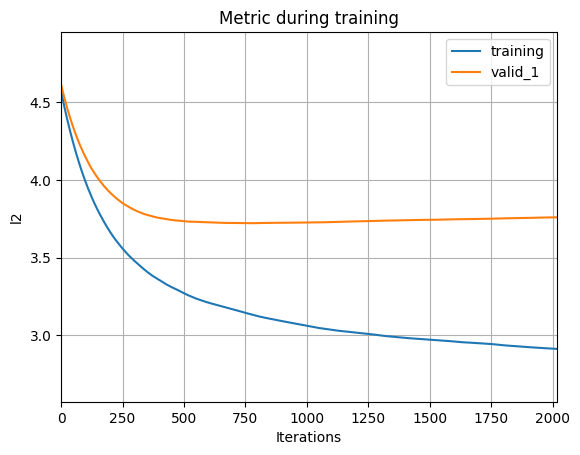

In [206]:
import lightgbm as lgb
lgb.plot_metric(lgbm_wrapper)

lgbm Test Data 실험

In [226]:
for k in CAT_FIELDS:
    Final_Test[k]=Final_Test[k].astype('category')
    
Final_Test_X = Final_Test.drop(columns=['Predict_Score'])
Final_Test_y = Final_Test.Predict_Score

In [117]:
test

,Unnamed: 0,USER_ID,Question_ID,HOSPITAL_CD,HOSPITAL_NM,ADD,HOSPITAL_ID,TIME,요양기관명,종별코드,...,시도코드명,시군구코드,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,x좌표,y좌표,Predict_Score
0,1,1034825,1034825_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,서울특별시 강남구 도산대로 119 K타워 5층,85156,2020-09-11 17:19:48,리팅성형외과의원,31,...,서울,110001,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,1
1,9,201020684119,201020684119_33732,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxNzAyIzMxIyQxIy...,로담한의원 강남점,"서울특별시 강남구 강남대로 498 3층 (논현동, 명성빌딩)",33732,2019-10-21 00:25:48,로담한의원,93,...,서울,110001,강남구,3444-7523,http://www.skincora.com,2015-10-21 00:00:00,4,127.023893,37.506695,1
2,13,1078855,1078855_203038,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxMzUxIzMxIyQyIy...,나나성형외과,"서울특별시 강남구 강남대로 492, 지상 2층",203038,2020-01-10 05:12:27,나나성형외과의원,31,...,서울,110001,강남구,02-544-0601,NaN,2018-05-28 00:00:00,20,127.024119,37.506211,1
3,14,1501770,1501770_47123,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzExIyQxIy...,리스펙성형외과의원,서울특별시 서초구 강남대로 441 서산빌딩 6층 (서초동),47123,2021-06-01 03:56:31,리스펙성형외과의원,31,...,서울,110021,서초구,02-532-0888,NaN,2019-10-31 00:00:00,2,127.025305,37.501747,1
4,16,582814,582814_54799,JDQ4MTg4MSM1MSMkMSMkNCMkMTMkNDgxOTYxIzMxIyQxIy...,자연과한의원 노원점,서울특별시 노원구 동일로 1417 2층,54799,2022-04-12 09:10:37,자연과한의원,93,...,서울,110022,노원구,02-951-1357,NaN,2012-04-05 00:00:00,1,127.059991,37.655041,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,3605,1405162,1405162_116235,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMTkxIzIxIyQxIy...,시안의원,"서울특별시 서초구 강남대로 439 8층 (서초동, 유화빌딩)",116235,2020-10-24 10:26:53,시안의원,31,...,서울,110021,서초구,534-5555,NaN,2013-10-15 00:00:00,3,127.025402,37.501546,1
1402,3607,1405162,1405162_85781,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkMzgxMTkxIzUxIyQxIy...,재시아성형외과의원,"서울특별시 강남구 선릉로 840, 3층",85781,2020-10-24 10:24:35,재시아성형외과의원,31,...,서울,110001,강남구,3442-1991,http://www.jaessia.com,1999-10-18 00:00:00,1,127.040740,37.526802,1
1403,3609,1405162,1405162_229060,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzIxIyQxIy...,강남역 데이원의원,서울특별시 서초구 강남대로 423 한승빌딩 4층 402호 (서초동),229060,2020-12-01 10:19:08,강남역데이원의원,31,...,서울,110021,서초구,02-594-5001,NaN,2019-12-03 00:00:00,1,127.025845,37.500259,1
1404,3627,1410677,1410677_76169,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkMzgxMTkxIzMxIyQxIy...,유앤아이의원 영등포점,서울특별시 영등포구 영중로 12 에쉐르빌딩 7층,76169,2021-09-08 04:46:22,유앤아이의원,31,...,서울,110013,영등포구,02-2636-6020,http://www.blueuro.co.kr,2018-10-12 00:00:00,6,126.906519,37.517634,1


In [227]:
Final_Test

,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,진료과목_마취통증의학과,진료과목_방사선종양학과,진료과목_병리과,진료과목_비뇨의학과,...,x,y,종별코드,시군구코드,개설일자,총의사수,TIME,USER_ID,HOSPITAL_ID,Predict_Score
0,0,0,0,0,0,0,0,0,0,0,...,0.632479,0.404976,0.5,0.00,0.869565,0.558824,0.739130,0.481110,0.823988,1
1,0,0,0,0,0,0,0,0,0,0,...,0.639677,0.366401,1.0,0.00,0.847826,0.117647,0.000000,0.899769,0.334891,1
2,0,0,0,0,0,0,0,0,0,0,...,0.640395,0.364644,0.5,0.00,0.913043,0.500000,0.217391,0.579029,0.947040,1
3,0,0,0,0,0,0,1,0,0,0,...,0.643883,0.348439,0.5,0.80,0.934783,0.058824,0.130435,0.830378,0.501558,1
4,0,0,0,0,0,0,0,0,0,0,...,0.747285,0.905001,1.0,0.84,0.782609,0.029412,0.391304,0.363146,0.585670,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,0,0,0,0,0,0,0,0,0,0,...,0.644173,0.347710,0.5,0.80,0.804348,0.088235,0.434783,0.755590,0.856698,1
1402,0,0,0,0,0,0,0,0,0,0,...,0.689858,0.439386,0.5,0.00,0.500000,0.029412,0.434783,0.755590,0.839564,1
1403,0,0,0,0,0,0,0,0,0,0,...,0.645492,0.343036,0.5,0.80,0.934783,0.029412,0.434783,0.755590,0.982866,1
1404,0,0,0,0,0,0,0,0,0,0,...,0.290058,0.406108,0.5,0.48,0.913043,0.176471,0.173913,0.762529,0.811526,1


In [228]:
# test data 실험

predict = lgbm_wrapper.predict(Final_Test_X)
mean_squared_error(predict, Final_Test_y.values)

54.32924655369462

In [ ]:
predict

In [ ]:
predict = np.ceil(predict)

In [ ]:
predict = np.where(predict > 10, 10, predict)
predict = np.where(predict < 0, 0, predict)

In [41]:
import datetime

In [42]:
submission['Predict_Score'] = predict

path = './result/'

now = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
submission.to_csv(f'{path}Submission_{now}.csv',encoding='utf-8', index=False)

In [ ]:
ls

### 위에 사용한 Tree Model들의 Hyper Parameter는 설정하기 귀찮고 힘든데 Optuna로 설정해보는 것에 목적

In [98]:
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc

font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
font_list[:]

['/usr/share/fonts/nanum/NanumBrush.ttf',
 '/usr/share/fonts/nanum/NanumPen.ttf',
 '/usr/share/fonts/nanum/NanumGothic.ttf',
 '/usr/share/fonts/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/nanum/NanumMyeongjoExtraBold.ttf',
 '/usr/share/fonts/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf',
 '/usr/share/fonts/nanum/NanumGothicExtraBold.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf',
 '/usr/share/fonts/nanum/NanumMyeongjoBold.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf']

In [99]:
fm.get_fontconfig_fonts()
font_location = '/usr/share/fonts/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()
# rc('font', family = font)

In [100]:
plt.rc('font', family=font_name)
print(plt.rcParams['font.family'])

['NanumGothic']


In [101]:
matplotlib.matplotlib_fname()

'/home/ubuntu/.conda/envs/lhs/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

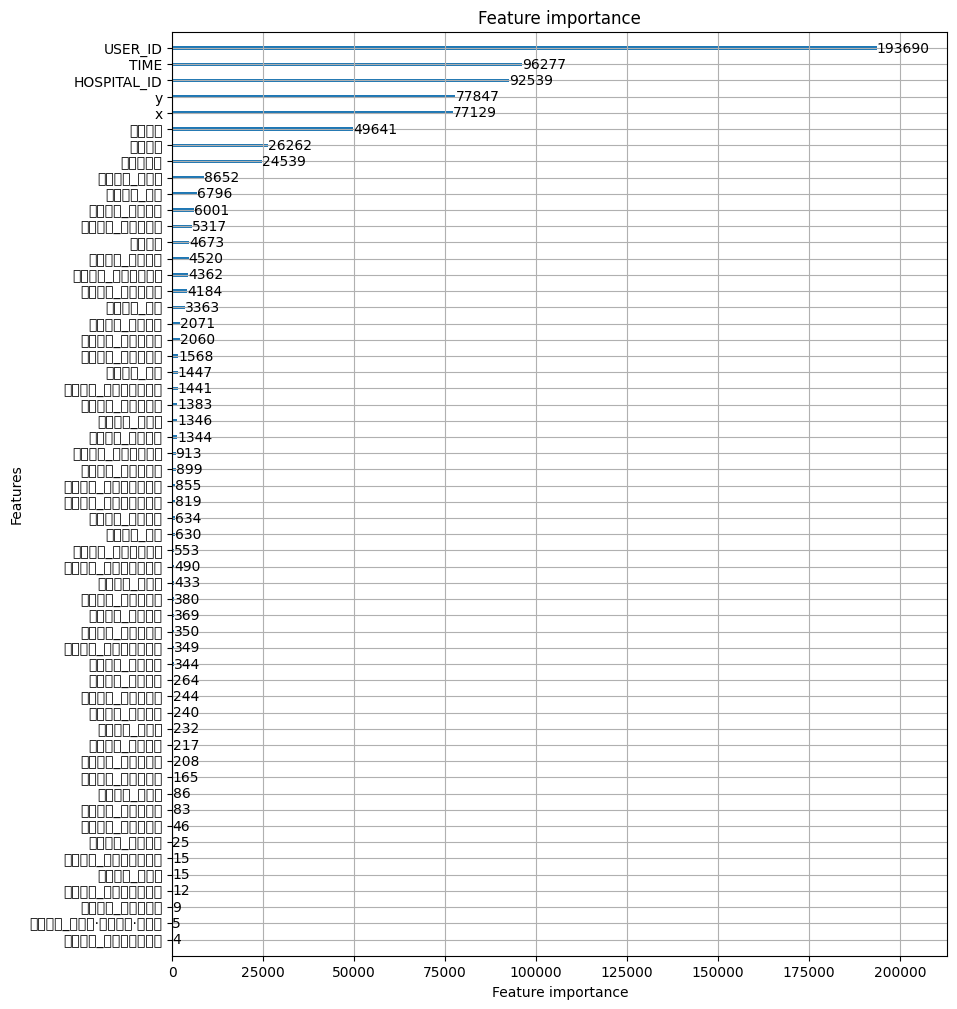

In [229]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)
plt.show()

### Optuna로 Tuning

In [59]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [244]:
sampler = TPESampler(seed=20) # 젤 많이 쓰이는 sampler, DL에서 optimizer 느낌

def objective(trial):
    dtrain = Dataset(X_train, label = y_train)
    dtest = Dataset(X_test, label = y_test)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'mae', 
        'boosting_type': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 3, 50),        # suggest_int 정수로 이동하면서 학습
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-9, 1e-2), # suggest_loguniform 함수를 써 줘야 소수점을 따라 학습
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = LGBMRegressor(**param) # ** = 가변적이라는 뜻
    lgb_model = model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=25)
    mse = mean_squared_error(y_test, lgb_model.predict(X_test))
    return mse

study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=50)



[I 2022-12-11 05:57:14,382] A new study created in memory with name: no-name-a009374a-be4c-4e8d-acd7-1a6ae746da94
[I 2022-12-11 05:57:26,290] Trial 0 finished with value: 3.6604985380753856 and parameters: {'max_depth': 31, 'learning_rate': 0.0019230744389466684, 'n_estimators': 2686, 'min_child_samples': 83, 'subsample': 0.4133727969145287}. Best is trial 0 with value: 3.6604985380753856.
[I 2022-12-11 05:57:33,154] Trial 1 finished with value: 4.617673262955521 and parameters: {'max_depth': 36, 'learning_rate': 4.474727510883045e-07, 'n_estimators': 1604, 'min_child_samples': 68, 'subsample': 0.4777500582881459}. Best is trial 0 with value: 3.6604985380753856.
[I 2022-12-11 05:57:43,655] Trial 2 finished with value: 4.331783843857601 and parameters: {'max_depth': 16, 'learning_rate': 0.00010721154021988967, 'n_estimators': 2371, 'min_child_samples': 86, 'subsample': 0.8138810771058443}. Best is trial 0 with value: 3.6604985380753856.
[I 2022-12-11 05:57:49,814] Trial 3 finished with 

[I 2022-12-11 06:01:54,999] Trial 28 finished with value: 3.598612786847089 and parameters: {'max_depth': 50, 'learning_rate': 0.009180679462012382, 'n_estimators': 2468, 'min_child_samples': 70, 'subsample': 0.7466163788174518}. Best is trial 12 with value: 3.5885126231729862.
[I 2022-12-11 06:02:10,041] Trial 29 finished with value: 3.669078033843009 and parameters: {'max_depth': 29, 'learning_rate': 0.0016242114923820466, 'n_estimators': 2724, 'min_child_samples': 88, 'subsample': 0.44700689312126424}. Best is trial 12 with value: 3.5885126231729862.
[I 2022-12-11 06:02:19,651] Trial 30 finished with value: 4.594334403306291 and parameters: {'max_depth': 22, 'learning_rate': 9.050278655595881e-06, 'n_estimators': 1914, 'min_child_samples': 80, 'subsample': 0.6446238550685318}. Best is trial 12 with value: 3.5885126231729862.
[I 2022-12-11 06:02:31,484] Trial 31 finished with value: 3.61792424193708 and parameters: {'max_depth': 47, 'learning_rate': 0.004037542715671343, 'n_estimator

### 위 코드에서 파라미터 추출하고 추가 학습까지 진행해 줘야 함

In [245]:
trial_params = {'max_depth': 23, 'learning_rate': 0.00990323848202835, 'n_estimators': 846, 'min_child_samples': 24, 'subsample': 0.8701277798440029}
trial_params2 = {'max_depth': 20, 'learning_rate': 0.009842725311877134, 'n_estimators': 2018, 'min_child_samples': 26, 'subsample': 0.4715832342831849}
trial_params3 = {'max_depth': 24, 'learning_rate': 0.008927289793026653, 'n_estimators': 4544, 'min_child_samples': 5, 'subsample': 0.40621052807670843}
trial_params4 = {'max_depth': 20, 'learning_rate': 0.003025159791216834, 'n_estimators': 2788, 'min_child_samples': 47, 'subsample': 0.8177492492343691}
trial_params5 = {'max_depth': 16, 'learning_rate': 0.021480437310798683, 'n_estimators': 1733, 'min_child_samples': 47, 'subsample': 0.6474291809870388}
trial_params6 = {'max_depth': 15, 'learning_rate': 0.004624565169981161, 'n_estimators': 2995, 'min_child_samples': 5, 'subsample': 0.7079717028641825}

trial_params7 = {'max_depth': 7, 'learning_rate': 0.009699629992649516, 'n_estimators': 2215, 'min_child_samples': 22, 'subsample': 0.7946691446096538}
trial_params8 = {'max_depth': 32, 'learning_rate': 0.0036079158200764488, 'n_estimators': 2892, 'min_child_samples': 15, 'subsample': 0.5690936063562986}

trial_params9 = {'max_depth': 23, 'learning_rate': 0.002322573604040508, 'n_estimators': 2641, 'min_child_samples': 60, 'subsample': 0.56151348552265}
trial_params10 = {'max_depth': 21, 'learning_rate': 0.008088481172841389, 'n_estimators': 2139, 'min_child_samples': 29, 'subsample': 0.6784846924213901}

trial_params11 = {'max_depth': 25, 'learning_rate': 0.004792080326674811, 'n_estimators': 1373, 'min_child_samples': 10, 'subsample': 0.996495461468459}
trial_params12 = {'max_depth': 27, 'learning_rate': 0.005817476343681444, 'n_estimators': 1229, 'min_child_samples': 21, 'subsample': 0.7178016416449223}

trial_params13 = {'max_depth': 50, 'learning_rate': 0.007448078123577035, 'n_estimators': 2999, 'min_child_samples': 63, 'subsample': 0.7248835183583329}

아직까지 2가 제일 좋음

parameter보다 중요한 것은 data


In [247]:
final_lgb_model = LGBMRegressor(**trial_params13)
final_lgb_model.fit(X_train, y_train)
final_lgb_pred = final_lgb_model.predict(X_test)
mean_squared_error(final_lgb_pred, y_test.values)

3.5885126231729862

data 추가하고 mse 3.68까지 낮아짐

근데 public score는 안 오름

trial_params2(3.60253146499597)로 점수가 올라감.. 파라미터가 이렇게 중요한가?



In [248]:
final_lgb_pred = final_lgb_model.predict(Final_Test_X)
final_lgb_pred

array([ 9.10743325, 10.63054638,  9.85527148, ...,  9.25337824,
        9.31208213,  9.07835146])

In [ ]:
# around
final_lgb_pred_around = np.around(final_lgb_pred)
final_lgb_pred_around

In [249]:
# ceil 소수점 올림
final_lgb_pred_ceil = np.ceil(final_lgb_pred)
final_lgb_pred_ceil

array([10., 11., 10., ..., 10., 10., 10.])

In [ ]:
# trunc, 버림
final_lgb_pred_trunc = np.trunc(final_lgb_pred)
final_lgb_pred_trunc

In [ ]:
final_lgb_pred_around

In [ ]:
# 예상 값의 범위 맞춰주기, around, 반올림

final_lgb_pred_around = np.where(final_lgb_pred_around > 10, 10, final_lgb_pred_around)
final_lgb_pred_around = np.where(final_lgb_pred_around < 0, 0, final_lgb_pred_around)
submission['Predict_Score'] = final_lgb_pred_around
submission['Predict_Score'].value_counts()

In [250]:
# 예상 값의 범위 맞춰주기, ceil

final_lgb_pred_ceil = np.where(final_lgb_pred_ceil > 10, 10, final_lgb_pred_ceil)
final_lgb_pred_ceil = np.where(final_lgb_pred_ceil < 0, 0, final_lgb_pred_ceil)
submission['Predict_Score'] = final_lgb_pred_ceil
submission['Predict_Score'].value_counts()

9.0     632
10.0    492
8.0     236
7.0      44
6.0       2
Name: Predict_Score, dtype: int64

In [ ]:
# 예상 값의 범위 맞춰주기, trunc

final_lgb_pred_trunc = np.where(final_lgb_pred_trunc > 10, 10, final_lgb_pred_trunc)
final_lgb_pred_trunc = np.where(final_lgb_pred_trunc < 0, 0, final_lgb_pred_trunc)
submission['Predict_Score'] = final_lgb_pred_trunc
submission['Predict_Score'].value_counts()

In [108]:
optuna.visualization.plot_param_importances(study_lgb)

NameError: name 'study_lgb' is not defined

In [109]:
import datetime

제출

In [251]:
submission['Predict_Score'] = final_lgb_pred_ceil

path = './result/'

now = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
submission.to_csv(f'{path}Submission_{now}.csv',encoding='utf-8', index=False)